In [ ]:
import pandas as pd
import numpy as np
RANDOM_STATE=2022
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, f1_score, hamming_loss
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression , Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from gensim.parsing import preprocess_string
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from collections import Counter, defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.multiclass import OneVsRestClassifier

!pip install fastparquet
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
from nltk.stem.wordnet import WordNetLemmatizer
import spacy, en_core_web_sm
nlp=en_core_web_sm.load()
nltk.download('punkt')
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 13.7 MB/s 
     |████████████████████████████████| 1.6 MB 55.9 MB/s 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#read the file
game_df = pd.read_parquet('https://github.com/canunj/deconstructing_games/blob/main/ranked_df.parquet.gzip?raw=true', engine='fastparquet')


In [ ]:
#filter the games from the year 2000 onwards
game_df = game_df[game_df.year>=2000]
game_df.shape

(17289, 33244)

In [ ]:
def feature_train(source,feats, targ=None, drop=None,scale=False):
  source = source[source['year'] >= 2000]
  one_hot = list(source.columns[33:])
  one_hot.append('cooperative')
  source[one_hot]=source[one_hot].fillna(0)

  feature_columns = ['num_votes','year','complexity','max_players','max_time','min_age','min_players', 'min_time', 'bayes_rating','cooperative','name','description','category','bgg_id','rank']
  
  func_cols = ['year','complexity','max_players','max_time','min_age','min_players', 'min_time','bayes_rating','num_votes']

  if drop:
    source = source.drop(columns=drop,axis=1)
    feature_columns = [x for x in feature_columns if x not in drop]
    func_cols = [x for x in func_cols if x not in drop]
  for feat in feats:
    ls = [col for col in source[one_hot] if col.startswith(feat)]
    feature_columns.extend(ls)

  
  features_df = source[feature_columns]
  
  def impute_func(df, dftype='x'):
    if dftype == 'x':
      for col in func_cols:
        if col in df.columns:
          med_imp=SimpleImputer(missing_values=np.nan,strategy='median')
          df[col]=med_imp.fit_transform(df[col].values.reshape(-1,1))[:,0]
        else:
          pass
      return df
    elif dftype == 'y':
      med_imp=SimpleImputer(missing_values=np.nan,strategy='median')
      df=med_imp.fit_transform(df.values.reshape(-1,1))[:,0]
      return df

  def scaler_func(df):
    scaler = preprocessing.MinMaxScaler()
    cols = [x for x in func_cols if x in df.columns]
    scaler.fit(df[cols])
    d_t = scaler.transform(df[cols]).T
    for idx, col in enumerate(cols):
      df[col] = d_t[idx]
    return df

  if targ:
    X = features_df.drop(columns=[targ], axis=1)
    y = features_df[targ]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
    
    X_train = impute_func(X_train)
    X_test = impute_func(X_test)
    y_train = impute_func(y_train,dftype='y')
    y_test = impute_func(y_test,dftype='y')

    if scale==True:
      X_train = scaler_func(X_train)
      X_test = scaler_func(X_test)

    return X_train, X_test, y_train, y_test
  else:
    X_train, X_val = train_test_split(features_df, test_size=0.2, random_state=RANDOM_STATE)
    
    X_train = impute_func(X_train)
    X_val = impute_func(X_val)
    
    return X_train, X_val

# Regression

In [ ]:
# #Plotting The graph of Bayes rating vs. No.of votes
# fig = plt.figure(figsize = (10, 5))
# plt.scatter(game_df.bayes_rating, game_df.num_votes )

# plt.xlabel("Bayes Rating")
# plt.ylabel("No. of votes")
# plt.show()


In [ ]:
# #Plotting The graph of Average rating vs. No.of votes
# fig = plt.figure(figsize = (10, 5))
# plt.scatter(game_df.avg_rating, game_df.num_votes )
# plt.xlabel("Average Rating")
# plt.ylabel("No. of votes")

In [ ]:
# #Plotting The graph of complexity vs. avg rating
# fig = plt.figure(figsize = (10, 5))
# plt.scatter(game_df.complexity, game_df.avg_rating )
# plt.xlabel("complexity")
# plt.ylabel("Avg Rating")

In [ ]:
# Correlation matrix to observe the core game features
core_features_df = game_df[game_df.columns[:33]]


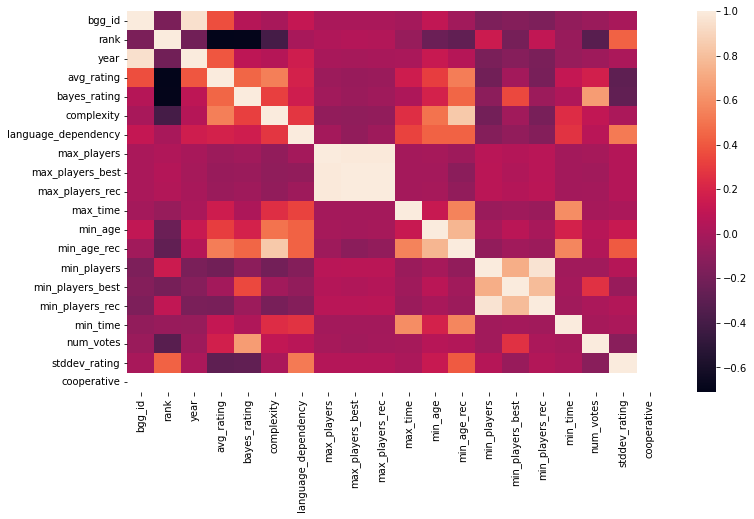

In [ ]:
cmatrix = core_features_df.corr()
fig= plt.figure(figsize= (12, 7))
sns.heatmap(cmatrix)
plt.show()

In [ ]:
#checking for NANs
#core_features_df.isna().sum()

In [ ]:
one_hot = list(game_df.columns[33:])
one_hot.append('cooperative')
game_df[one_hot]=game_df[one_hot].fillna(0)

#Trying to extract  mechanical, categories & game types and combining it with some of the core features 
mec_traits =[col for col in game_df[one_hot] if col.startswith('mechanic_')]
game_type_traits =[col for col in game_df[one_hot] if col.startswith('game_type_')]
#category_traits =[col for col in game_df[one_hot] if col.startswith('category_')]
family = [col for col in game_df[one_hot] if col.startswith('family_')]
publisher_names =[col for col in game_df[one_hot] if col.startswith('publisher_')]
feature_columns = ['complexity','max_players','max_time','min_age','min_players', 'min_time', 'bayes_rating','cooperative']
feature_columns.extend(mec_traits)
feature_columns.extend(game_type_traits)
#feature_columns.extend(category_traits)
feature_columns.extend(publisher_names)
feature_columns.extend(family)


In [ ]:
# dataframe has core features + mechanical traits + categories + game type
features_df= game_df[feature_columns]
features_df.dropna(subset=['bayes_rating'], inplace=True,axis=0)
print(features_df.shape)

(17288, 12058)


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Using Single Train Test Split

In [ ]:
# Train Test Split
X = features_df.drop(columns=['bayes_rating'], axis=1)

y = features_df['bayes_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
print(X_train.shape, y_train.shape)

(12966, 12057) (12966,)


In [ ]:
target_cols=['complexity','max_players','max_time','min_age','min_players', 'min_time']

In [ ]:
#Using a simple imputer to replace the nans in the dataset

# median imputed
median_imputer = SimpleImputer(strategy='median')
median_imputed= median_imputer.fit_transform(X_train[target_cols])
X_train[['complexity','max_players','max_time','min_age','min_players', 'min_time']]= median_imputed

median_imputed_test = median_imputer.transform(X_test[target_cols])
X_test[['complexity','max_players','max_time','min_age','min_players', 'min_time']]= median_imputed_test

#X_test.shape

In [ ]:
# using RandomForestRegressor
regr = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs= -1).fit(X_train, y_train)
y_pred_rf = regr.predict(X_test)
print("Training set score: {:.2f}".format(regr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(regr.score(X_test, y_test)))


Training set score: 0.96
Test set score: 0.69


In [ ]:
# using GradientBoostingRegressor
gbrt = GradientBoostingRegressor(random_state=RANDOM_STATE).fit(X_train, y_train)
gbrt_predict = gbrt.predict(X_test)
print("Training set score: {:.2f}".format(gbrt.score(X_train, y_train)))
print("Test set score: {:.2f}".format(gbrt.score(X_test, y_test)))

Training set score: 0.58
Test set score: 0.52


Plotting Feature Importance

In [ ]:
feature_importance = regr.feature_importances_
# sorted_idx = (np.argsort(feature_importance))
# pos = np.arange(sorted_idx.shape[0]) 
# fig = plt.figure(figsize=(15, 40))

# plt.barh(pos, feature_importance[sorted_idx])
# plt.yticks(pos, np.array(X_feat.columns)[sorted_idx])
# plt.title("Feature Importance ")


# fig.tight_layout()
# plt.show()

In [ ]:
sorted_indices = np.argsort(feature_importance)[::-1]
 
feat_labels = X_feat.columns
key_features = []
for f in range(286):
  
      print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            feature_importance[sorted_indices[f]]))
      key_features.append(feat_labels[sorted_indices[f]])

Hyperparameter Tuning with Gridsearch- Random Forest Regressor

In [ ]:
# using grid search cv to find the optimal parameters
param_grid = {  'bootstrap': [True], 'max_depth': [100,150, 200, 250], 'max_features':["auto",'sqrt'], 'n_estimators': [ 100, 1000,10000 ]}
regr = RandomForestRegressor( random_state= RANDOM_STATE)
g_search = GridSearchCV(estimator = regr, param_grid = param_grid, cv=3,  n_jobs = -1, verbose = 0)

g_search.fit(X_train, y_train)
print('Grid best parameter (max. accuracy): ', g_search.best_params_)
print('Grid best score (accuracy): ', g_search.best_score_)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
print('Grid best parameter (max. accuracy): ', g_search.best_params_)
print('Grid best score (accuracy): ', g_search.best_score_)

Grid best parameter (max. accuracy):  {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 250}
Grid best score (accuracy):  0.5568006559746987


Hyperparameter Tuning with Gridsearch- Gradient Boosting Regressor

In [ ]:
gbc = GradientBoostingRegressor()
parameters = {
    "n_estimators":[100,150,200,250],
    "max_depth":[10, 50, 100, 150],
    "learning_rate":[0.1,0.5,0.8,1]
}
cv = GridSearchCV(estimator= gbc,param_grid= parameters,cv=5,n_jobs = -1)
cv.fit(X_train, y_train)

print('Grid best parameter (max. accuracy): ', cv.best_params_)
print('Grid best score (accuracy): ', cv.best_score_)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Grid best parameter (max. accuracy):  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
Grid best score (accuracy):  0.5596879878944575


#Game Category Classification based on Game Description + Mechanics + Game Type + Family features

In [ ]:
game_df= game_df[game_df.year>=2000]

In [ ]:
one_hot = list(game_df.columns[33:])
one_hot.append('cooperative')
game_df[one_hot]=game_df[one_hot].fillna(0)

#Extracting  mechanical, family & game types and using them as predictor features along with descriptions
mec_traits =[col for col in game_df[one_hot] if col.startswith('mechanic_')]
game_type_traits =[col for col in game_df[one_hot] if col.startswith('game_type_')]
family = [col for col in game_df[one_hot] if col.startswith('family_')]

In [ ]:
feature_columns = ['description','category']
feature_columns.extend(mec_traits)
feature_columns.extend(game_type_traits)
feature_columns.extend(family)

In [ ]:
game_category_df = game_df[feature_columns]

In [ ]:
# filling Nans in category column with "no category"
game_category_df['category']= game_category_df['category'].fillna('["no category"]')

In [ ]:
import ast
# category is the target variable
# cleaning the category column and converting it from a string to list of strings

game_category_df['cleaned_category'] = game_category_df['category'].apply(lambda x: ast.literal_eval(x))




In [ ]:
# checking for nans
print(game_category_df.isna().sum())
game_category_df.dropna(inplace=True)
#game_category_df.isna().sum()

description                               1
category                                  0
mechanic_Acting                           0
mechanic_Action Drafting                  0
mechanic_Action Points                    0
                                         ..
family_Word Games: Guess the Word         0
family_Word Games: Guess the Word'        0
family_Word Games: Spelling / Letters     0
family_Word Games: Spelling / Letters'    0
cleaned_category                          0
Length: 5281, dtype: int64


In [ ]:
# function for text cleaning of descriptions

# Create WordNetLemmatizer object
wnl = WordNetLemmatizer()

def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", str(text) )
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",str(text)) 
    # Create a list of tokens
    list1 = nltk.word_tokenize(text)
    # Lemmatize
    lemmatized_string = ' '.join([wnl.lemmatize(words) for words in list1])
    # remove whitespaces 
    text = ' '.join(lemmatized_string.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

# removal of stopwords
stop_words = set(stopwords.words('english'))
stop_words_spa=set(stopwords.words('spanish'))

# function to remove stopwords
def remove_stopwords(text):
    if text is not None:
      no_stopword_text = [w for w in text.split() if not w in (stop_words or stop_words_spa)]
      return ' '.join(no_stopword_text)





game_category_df['cleaned_description'] = game_category_df['description'].apply(clean_text)
game_category_df['cleaned_description'] = game_category_df['cleaned_description'].apply(remove_stopwords)
game_category_df.head()

,description,category,mechanic_Acting,mechanic_Action Drafting,mechanic_Action Points,mechanic_Action Queue,mechanic_Action Retrieval,mechanic_Action Timer,mechanic_Action/Event,mechanic_Advantage Token,...,family_Video Game Theme: The Oregon Trail',family_Webcomics: Dork Tower',family_Webcomics: Penny Arcade',family_Word Games: First Letter Given',family_Word Games: Guess the Word,family_Word Games: Guess the Word',family_Word Games: Spelling / Letters,family_Word Games: Spelling / Letters',cleaned_category,cleaned_description
340,Described by the designer as a cross between D...,"['Bluffing', 'Card Game']",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Bluffing, Card Game]",described designer cross doris franks banana r...
413,Northwest India at the beginning of the 18th c...,"['Bluffing', 'Political']",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Bluffing, Political]",northwest india beginning th century rule gran...
416,"In Citadels, players take on new roles each ro...","['Bluffing', 'Card Game', 'City Building', 'De...",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Bluffing, Card Game, City Building, Deduction...",citadels player take new role round represent ...
419,This game uses a collection of smallish hexago...,"['Abstract Strategy', 'Medieval', 'Territory B...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Abstract Strategy, Medieval, Territory Building]",game us collection smallish hexagon cluster ar...
428,"Warangel is a light, fantasy wargame, comprisi...","['Fantasy', 'Mythology', 'Print & Play', 'Warg...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Fantasy, Mythology, Print & Play, Wargame]",warangel light fantasy wargame comprising warr...


In [ ]:
#game_category_df.query('name=="Citadels"')[['cleaned_category']]

In [ ]:
game_category_df.shape

(17288, 5282)

In [ ]:
# Using MultilabelBinarizer to one hot encode the target variable

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(game_category_df['cleaned_category'])

# transform target variable
y = multilabel_binarizer.transform(game_category_df['cleaned_category'])


In [ ]:
#multilabel_binarizer.classes_

array(['Abstract Strategy', 'Action / Dexterity', 'Adventure',
       'Age of Reason', 'American Civil War', 'American Indian Wars',
       'American Revolutionary War', 'American West', 'Ancient',
       'Animals', 'Arabian', 'Aviation / Flight', 'Bluffing', 'Book',
       'Card Game', "Children's Game", 'City Building', 'Civil War',
       'Civilization', 'Collectible Components', 'Comic Book / Strip',
       'Deduction', 'Dice', 'Economic', 'Educational', 'Electronic',
       'Environmental', 'Expansion for Base-game', 'Exploration',
       'Fan Expansion', 'Fantasy', 'Farming', 'Fighting', 'Game System',
       'Horror', 'Humor', 'Industry / Manufacturing', 'Korean War',
       'Mafia', 'Math', 'Mature / Adult', 'Maze', 'Medical', 'Medieval',
       'Memory', 'Miniatures', 'Modern Warfare',
       'Movies / TV / Radio theme', 'Murder/Mystery', 'Music',
       'Mythology', 'Napoleonic', 'Nautical', 'Negotiation',
       'Novel-based', 'Number', 'Party Game', 'Pike and Shot', 'Pirate

In [ ]:
# Using Cleaned Description as input feature
X= game_category_df.drop(columns=['description', 'category', 'cleaned_category'], axis=1)
X.shape

(17288, 5279)

In [ ]:
# Split into train test split
xtrain, xtest, ytrain, ytest = train_test_split(X,y, random_state=RANDOM_STATE)
xtrain.shape,ytrain.shape

((12966, 5279), (12966, 85))

In [ ]:
# create TF-IDF features
vectorizer=TfidfVectorizer(max_features = 10000, ngram_range = (1,2),min_df=0.01)
X_train_des = vectorizer.fit_transform(xtrain['cleaned_description']).toarray()

X_test_des = vectorizer.transform(xtest['cleaned_description']).toarray()

xtrain = xtrain.drop(columns='cleaned_description')
xtest = xtest.drop(columns='cleaned_description')

In [ ]:
# Combining the original one hot encoded columns(mech, family, game_type) along with the tfidf vector columns in xtrain, xtest
for i, col in enumerate(vectorizer.get_feature_names()):
    xtrain[col] = X_train_des[:, i]
    xtest[col] = X_test_des[:, i]

xtrain.shape, xtest.shape

((12966, 6946), (4322, 6946))

**Train and Evaluate Classifiers**

In [ ]:
# evaluation metrics - accuracy, hamming loss, precision, recall & F1 score
ModelsPerformance = {}

def metricsReport(modelName, test_labels, predictions):
    

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + modelName + " Model Metrics-----")
    print("Hamming Loss: {:.4f}\nPrecision:\n  - Micro: {:.4f}\nRecall:\n  - Micro: {:.4f}\nF1-measure:\n  - Micro: {:.4f}"\
          .format(hamLoss, micro_precision, micro_recall, micro_f1))
    ModelsPerformance[modelName] = micro_f1

In [ ]:
# Logistic Regression
lr = LogisticRegression(random_state= RANDOM_STATE)

log_reg = OneVsRestClassifier(lr)
# fit model on train data
log_reg.fit(xtrain, ytrain)
# make predictions for test set
logPreds = log_reg.predict(xtest)
metricsReport("Logistic Regression", ytest, logPreds)

------Logistic Regression Model Metrics-----
Accuracy: 0.1988
Hamming Loss: 0.0206
Precision:
  - Micro: 0.8177
Recall:
  - Micro: 0.4509
F1-measure:
  - Micro: 0.5813


In [ ]:
# GradientBoostingClassifier
boostClassifier = OneVsRestClassifier(GradientBoostingClassifier(random_state= RANDOM_STATE),n_jobs=-1)
boostClassifier.fit(xtrain, ytrain)
boostPreds = boostClassifier.predict(xtest)
metricsReport("Gradient Boosting", ytest, boostPreds)

------Gradient Boosting Model Metrics-----
Accuracy: 0.1606
Hamming Loss: 0.0230
Precision:
  - Micro: 0.7196
Recall:
  - Micro: 0.4466
F1-measure:
  - Micro: 0.5512


In [ ]:
# SVM
svmClassifier = OneVsRestClassifier(LinearSVC(random_state= RANDOM_STATE), n_jobs=-1)
svmClassifier.fit(xtrain, ytrain)
svmPreds= svmClassifier.predict(xtest)
metricsReport("SVC ", ytest, svmPreds)

------SVC  Model Metrics-----
Accuracy: 0.2036
Hamming Loss: 0.0216
Precision:
  - Micro: 0.7147
Recall:
  - Micro: 0.5300
F1-measure:
  - Micro: 0.6087


In [ ]:
# nbClassifier

nbClassifier = OneVsRestClassifier(MultinomialNB())
nbClassifier.fit(xtrain, ytrain)

nbPreds = nbClassifier.predict(xtest)
metricsReport("Multinomial NB",  ytest, nbPreds)

------Multinomial NB Model Metrics-----
Accuracy: 0.1333
Hamming Loss: 0.0253
Precision:
  - Micro: 0.6592
Recall:
  - Micro: 0.4177
F1-measure:
  - Micro: 0.5114


Comparison on different models based on their Micro-F1 score

In [ ]:
print("  Model Name " + " "*10 + "| Micro-F1 Score")
print("-------------------------------------------")
for key, value in ModelsPerformance.items():
    print("  " + key, " "*(20-len(key)) + "|", round(value,3))
    print("-------------------------------------------")

  Model Name           | Micro-F1 Score
-------------------------------------------
  Logistic Regression  | 0.581
-------------------------------------------
  Gradient Boosting    | 0.551
-------------------------------------------
  SVC                  | 0.609
-------------------------------------------
  Multinomial NB       | 0.511
-------------------------------------------


In [ ]:
# #Trying diffesrent threshold values to see it effects our f1 score

# # Predicting probabilities 
#y_pred_prob = svmClassifier.predict_proba(xtest)

# scores=[]
# hamming_scores=[]
# threshold_values =[0.3, 0.5, 0.7]
# for t in threshold_values:
#   y_pred_new = (y_pred_prob >= t).astype(int)
#   f1_scores= f1_score(ytest, y_pred_new, average="micro")
#   hammingloss = hamming_loss(ytest, y_pred)
#   scores.append(round(f1_scores,3))
#   hamming_scores.append(round(hammingloss,3))

# print(scores)
# print(hamming_scores)

In [ ]:
#t = 0.3 # threshold value
#y_pred_new = (y_pred_prob >= t).astype(int)

# Actual categories
print(game_category_df.cleaned_category.iloc[14])


# using inverse_transform( ) function along with the MultiLabelBinarizer( ) object to convert the predicted arrays into game categories
multilabel_binarizer.inverse_transform(svmPreds)[14]


['Card Game', 'Party Game']


('Party Game', 'Word Game')

Using Baseline Dummy Classifier for comparison

DummyClassifier is a classifier that makes predictions using simple rules, which can be useful as a baseline for comparison against actual classifiers, especially with imbalanced classes.

In [ ]:
from sklearn.dummy import DummyClassifier

clf_dummy = DummyClassifier(strategy='stratified',random_state=RANDOM_STATE) 
#establishing random_state for reproducibility
clf_dummy.fit(xtrain, ytrain)
y_pred_dummy = clf_dummy.predict(xtest)

In [ ]:
round(f1_score(ytest, y_pred_dummy, average="micro"),3)

0.059

**Hyperparameter Tuning on Linear SVC - using GridSearch**

In [ ]:
param_grid = {'estimator__C' : [0.01,0.1, 1,10],'estimator__penalty':['l1','l2'], 'estimator__loss':['hinge', 'squared_hinge'],
              'estimator__max_iter': [1000, 2000,3000]}

In [ ]:
base_estimator = OneVsRestClassifier(LinearSVC(random_state=RANDOM_STATE))
gsearch_cv = GridSearchCV(base_estimator, param_grid, scoring='f1_micro', n_jobs=-1, verbose=0, cv=3 )


# fitting the model for grid search 
gsearch_cv.fit(xtrain, ytrain)
 
# print best parameter after tuning 
print(gsearch_cv.best_params_) 
grid_predictions = gsearch_cv.predict(xtest) 

{'estimator__C': 1, 'estimator__loss': 'hinge', 'estimator__max_iter': 1000, 'estimator__penalty': 'l2'}


In [ ]:
# param_grid = {'estimator__alpha' : [0.0001,0.001],'estimator__penalty':['l1','l2'], 'estimator__loss':['hinge', 'log_loss', 'log']}

In [ ]:
# from sklearn.linear_model import SGDClassifier
# base_estimator = OneVsRestClassifier(SGDClassifier(random_state=RANDOM_STATE))
# gsearch_cv = GridSearchCV(base_estimator, param_grid, scoring='f1_micro', n_jobs=-1, verbose=0, cv=3 )


# # fitting the model for grid search 
# gsearch_cv.fit(xtrain, ytrain)
 
# # print best parameter after tuning 
# print(gsearch_cv.best_params_) 
# print(gsearch_cv.best_score_)
# grid_predictions = gsearch_cv.predict(xtest) 

{'estimator__alpha': 0.0001, 'estimator__loss': 'hinge', 'estimator__penalty': 'l1'}
0.6008024188674492


Fit The best estimator

In [ ]:
print("F1 score - {}".format(round(gsearch_cv.best_score_, 3)))
print("Prescision score - {}".format(round(precision_score(ytest, grid_predictions, average='micro'),3)))
print("Recall score - {}".format(round(recall_score(ytest, grid_predictions, average='micro'),3)))
print("Hamming Loss - {}".format(round(hamming_loss(ytest, grid_predictions),3)))


F1 score - 0.601
Prescision score - 0.758
Recall score - 0.519
Hamming Loss - 0.02


**Cross Validation- Using LinearSVC Classifier**

In [ ]:
from yellowbrick.model_selection import CVScores
from sklearn.model_selection import KFold
from yellowbrick.classifier import ROCAUC , PrecisionRecallCurve


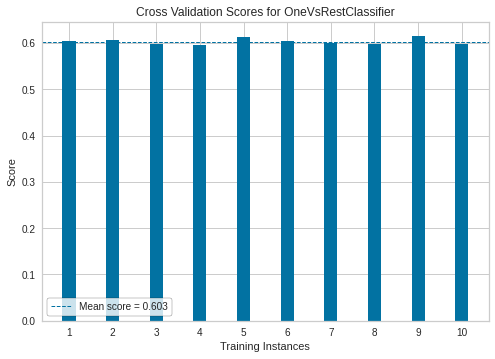

In [ ]:
# Create a cross-validation strategy
cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# Instantiate the classification model and visualizer
base_estimator = OneVsRestClassifier(LinearSVC(random_state=RANDOM_STATE, C=1, penalty='l2'))
visualizer = CVScores(base_estimator, cv=cv, scoring='f1_micro')

visualizer.fit(xtrain, ytrain)       # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

**Precision Recall curve- Using LinearSVC Classifier**

In [ ]:
 # SVM
svmClassifier = OneVsRestClassifier(LinearSVC(random_state= RANDOM_STATE, C=1), n_jobs=-1)
svmClassifier.fit(xtrain, ytrain)
y_score = svmClassifier.decision_function(xtest)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
n_classes= y.shape[1]
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(ytest[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(ytest[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    ytest.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(ytest, y_score, average="micro")

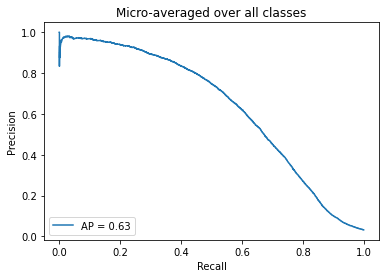

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

In [ ]:
acc = []
acc_tr = []
i = 0
df = pd.DataFrame(columns = ['c','train_acc','test_acc'])
for c in [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]:
    svm = OneVsRestClassifier(LinearSVC( C=c))
    svm.fit(xtrain, ytrain)
   
    p_tr = svm.predict(xtrain)
    a_tr = f1_score(ytrain, p_tr, average='micro')
    
    pred = svm.predict(xtest)
    a = f1_score(ytest, pred, average='micro')
    

    acc_tr.append(a_tr)
    acc.append(a)
    df.loc[i] = [c,a_tr,a]
    i=i+1


df

,c,train_acc,test_acc
0,0.0001,0.110735,0.111935
1,0.0010,0.250055,0.244165
2,0.0100,0.464479,0.432013
3,0.1000,0.730692,0.588988
4,1.0000,0.942287,0.608683
5,10.0000,0.993122,0.552398
6,100.0000,0.996593,0.530115
7,1000.0000,0.994750,0.527260
8,10000.0000,0.990747,0.525448


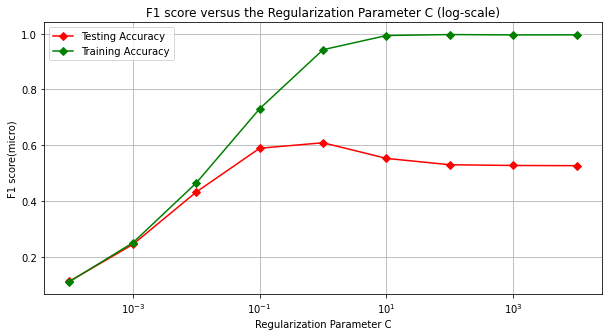

In [ ]:
c = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

plt.subplots(figsize=(10, 5))
plt.semilogx(c, acc,'-gD' ,color='red' , label="Testing Accuracy")
plt.semilogx(c, acc_tr,'-gD' , label="Training Accuracy")
plt.grid(True)
plt.xlabel("Regularization Parameter C")
plt.ylabel("F1 score(micro)")
plt.legend()
plt.title('F1 score versus the Regularization Parameter C (log-scale)')
plt.show()

Using multibinarizer inverse function to manually observe categories assigned by the classifier

In [ ]:
# Actual categories
print(game_category_df.cleaned_category.iloc[28])


# using inverse_transform( ) function along with the MultiLabelBinarizer( ) object to convert the predicted arrays into game categories
multilabel_binarizer.inverse_transform(svmPreds)[28]


['Abstract Strategy']


('Abstract Strategy',)